In [1]:
from PIL import Image
import requests
import copy
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time

from transformers import AutoProcessor, AutoModelForCausalLM
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

2024-11-18 21:31:57.698902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731936717.713635 2334701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731936717.717967 2334701 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 21:31:57.735029: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device = torch.device("cuda")

In [3]:
def plot_bbox(image, data, save_path=None):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)  # Close the figure to free memory
    # Show the plot
    # plt.show()

def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [4]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, save_path, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        #plt.close(fig)  # Close the figure to free memory

    plt.show()

In [5]:
def florence2_inference(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer
    
def sam2_inference(predictor, input_box, input_point, input_label):

    if len(input_point[0]) > 0:
        masks, scores, logits = predictor.predict(point_coords=input_point, point_labels=input_label, box=input_box, multimask_output=False,)
    else:
        masks, scores, logits = predictor.predict(box=input_box, multimask_output=False,)

    return masks, scores, logits

In [6]:
# load Florence-2-Large checkpoints
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [8]:
# load sam2.1 checkpoints
sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

Florence2 inference time for sampledata/test/flare_0167_jpg.rf.0b5b9b75a2bcf9392b51a3369dc1b2e9.jpg: 0.55 seconds


/home/jaswinder/code/florence2/fire-and-smoke-detectors/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:718.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/jaswinder/code/florence2/fire-and-smoke-detectors/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/jaswinder/code/florence2/fire-and-smoke-detectors/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:720.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/jaswinder/code/florence2/fire-and-smoke-detectors/sam2/modeling/sam/tra

SAM2 inference time for sampledata/test/flare_0167_jpg.rf.0b5b9b75a2bcf9392b51a3369dc1b2e9.jpg: 0.12 seconds


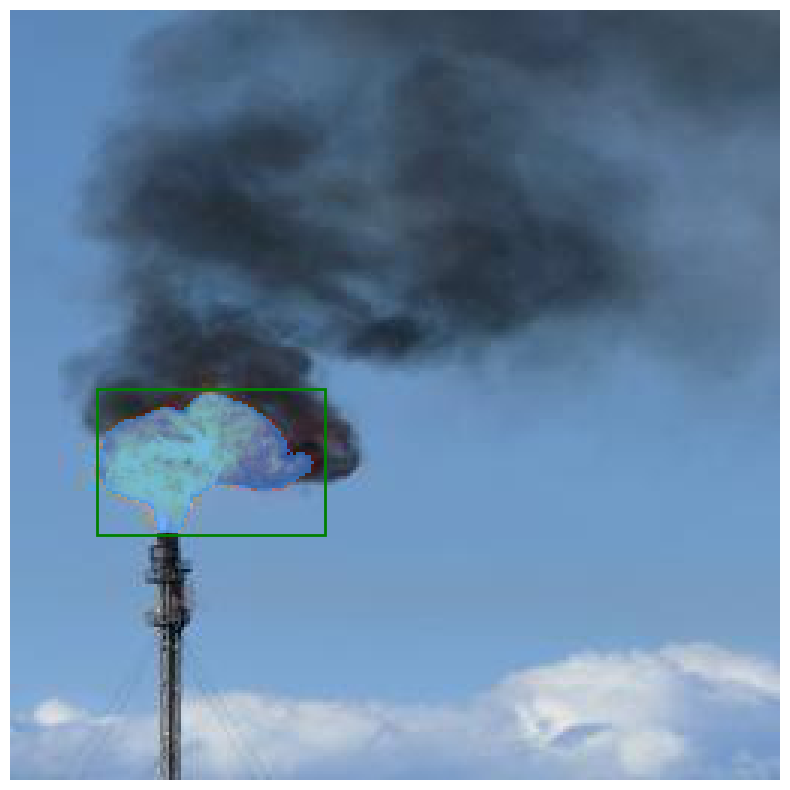

Florence2 inference time for sampledata/test/flare_0089_jpg.rf.4b52d9620ee0c678eda0fae322f2f8d6.jpg: 0.16 seconds
SAM2 inference time for sampledata/test/flare_0089_jpg.rf.4b52d9620ee0c678eda0fae322f2f8d6.jpg: 0.14 seconds


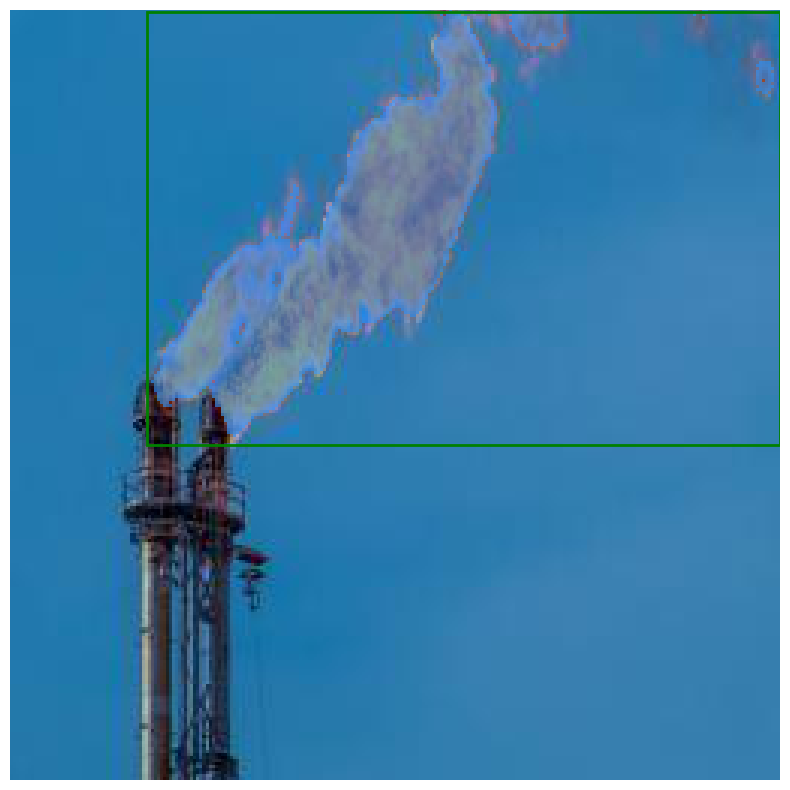

Florence2 inference time for sampledata/test/flare_0216_jpg.rf.012322a713a936a586391e76108040db.jpg: 0.13 seconds
SAM2 inference time for sampledata/test/flare_0216_jpg.rf.012322a713a936a586391e76108040db.jpg: 0.14 seconds


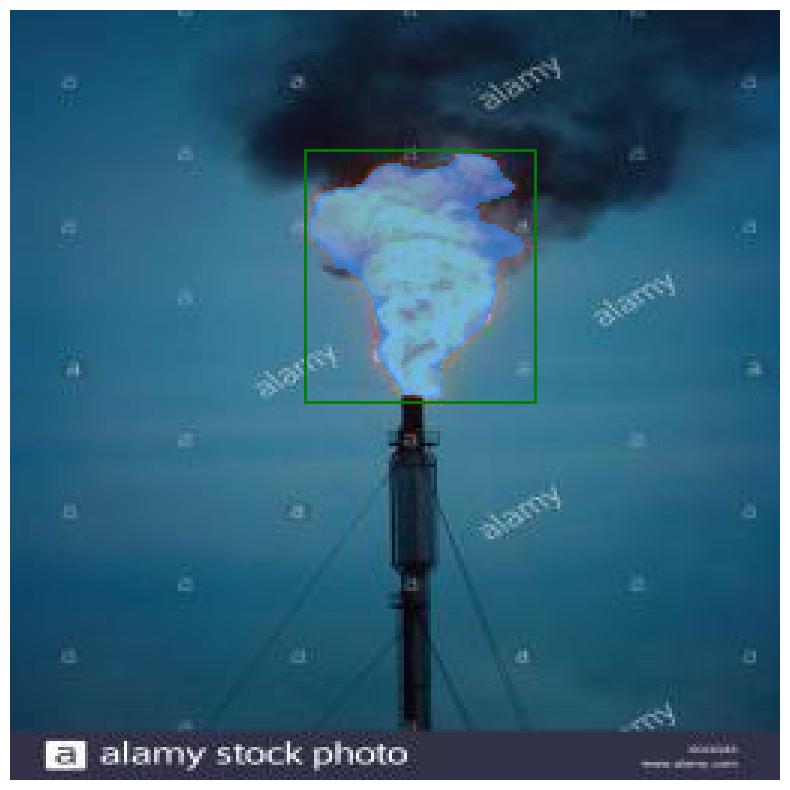

Florence2 inference time for sampledata/test/flare_0078_jpg.rf.a64799ec19d6f0a6063a10beb161842b.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0078_jpg.rf.a64799ec19d6f0a6063a10beb161842b.jpg: 0.14 seconds


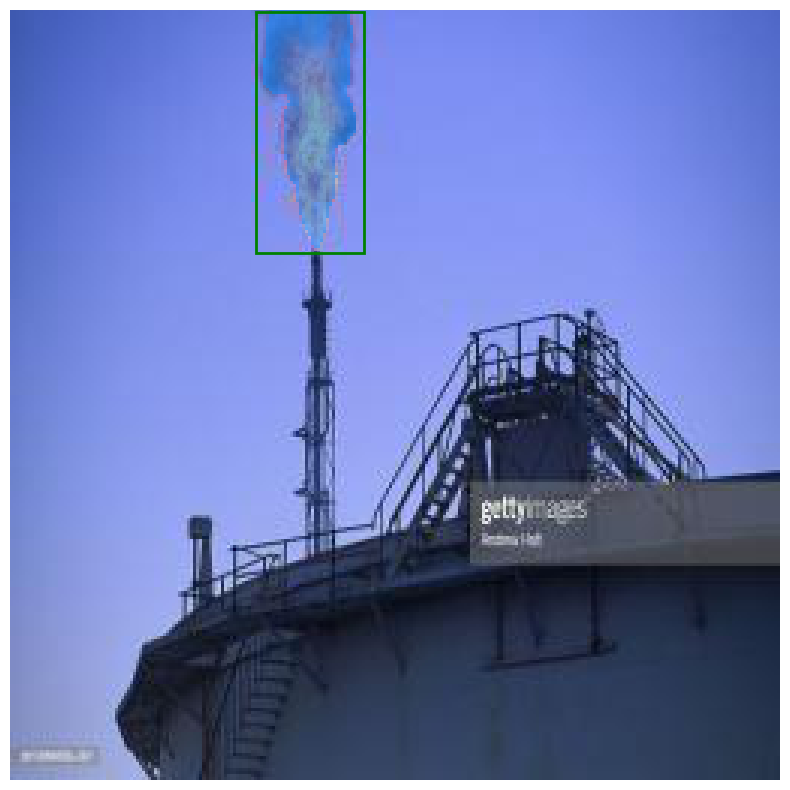

Florence2 inference time for sampledata/test/flare_0104_jpg.rf.7c27619b88daeddd0719601cd801858d.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0104_jpg.rf.7c27619b88daeddd0719601cd801858d.jpg: 0.14 seconds


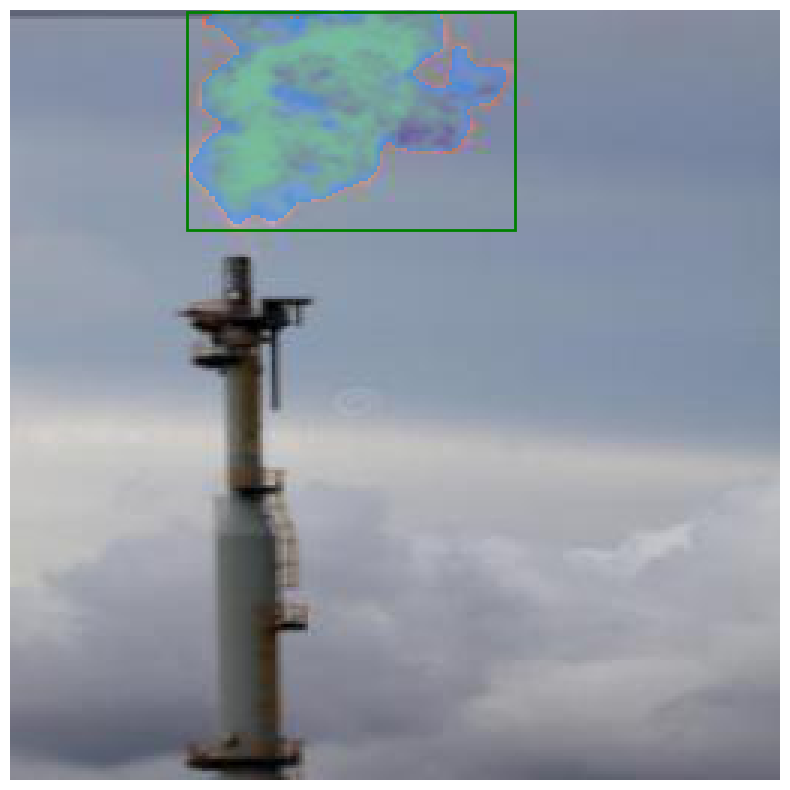

Florence2 inference time for sampledata/test/flare_0059_jpg.rf.7f8f462c357e83594b0671039c444331.jpg: 0.11 seconds
SAM2 inference time for sampledata/test/flare_0059_jpg.rf.7f8f462c357e83594b0671039c444331.jpg: 0.14 seconds


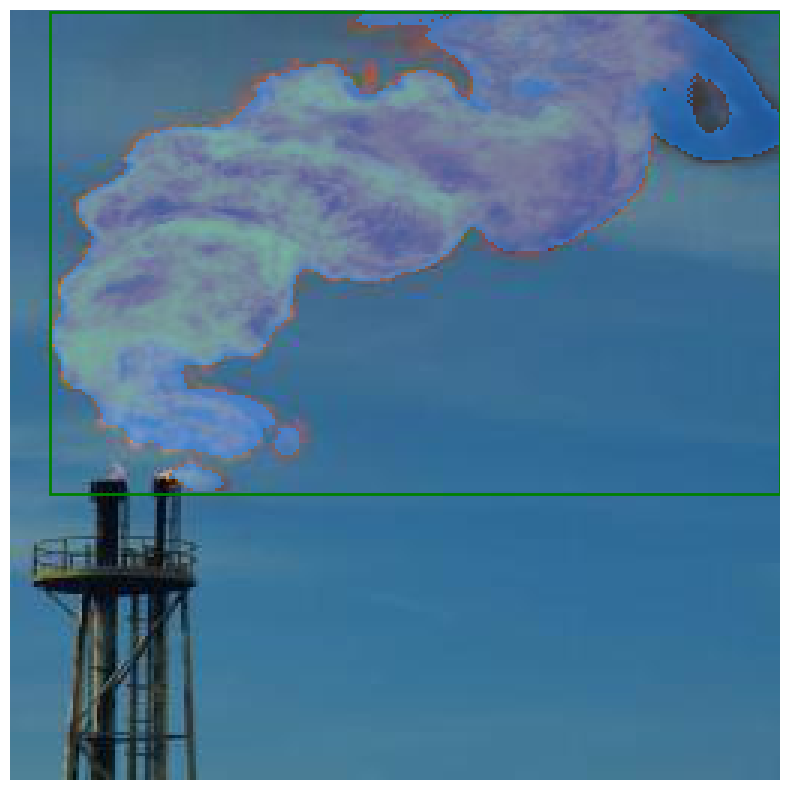

Florence2 inference time for sampledata/test/flare_0222_jpg.rf.ce0ac1618ab9859a0c55a734eaa19ade.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0222_jpg.rf.ce0ac1618ab9859a0c55a734eaa19ade.jpg: 0.14 seconds


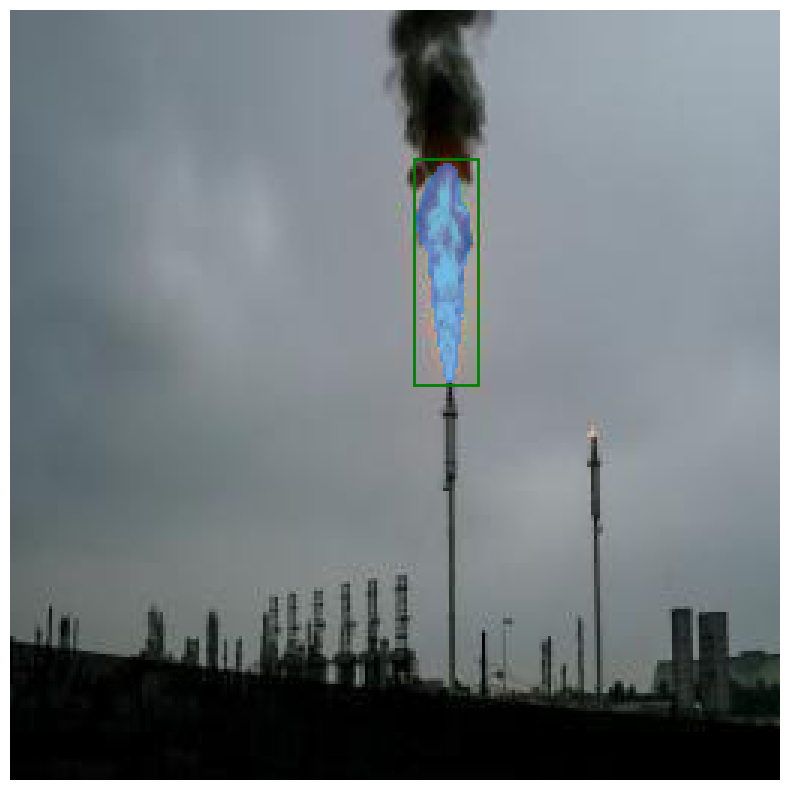

Florence2 inference time for sampledata/test/flare_0029_jpg.rf.42a6c6a13dd369e6e7ce4413cd3c6235.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0029_jpg.rf.42a6c6a13dd369e6e7ce4413cd3c6235.jpg: 0.14 seconds


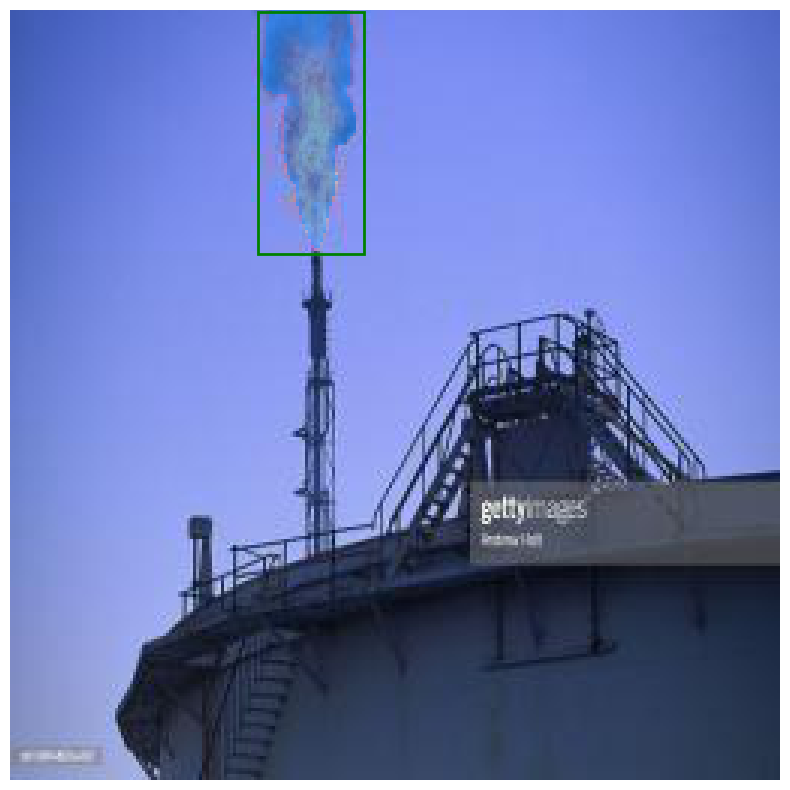

Florence2 inference time for sampledata/test/flare_0014_jpg.rf.6ea81b6696f97d0d215876598a4c1ff8.jpg: 0.13 seconds
SAM2 inference time for sampledata/test/flare_0014_jpg.rf.6ea81b6696f97d0d215876598a4c1ff8.jpg: 0.14 seconds


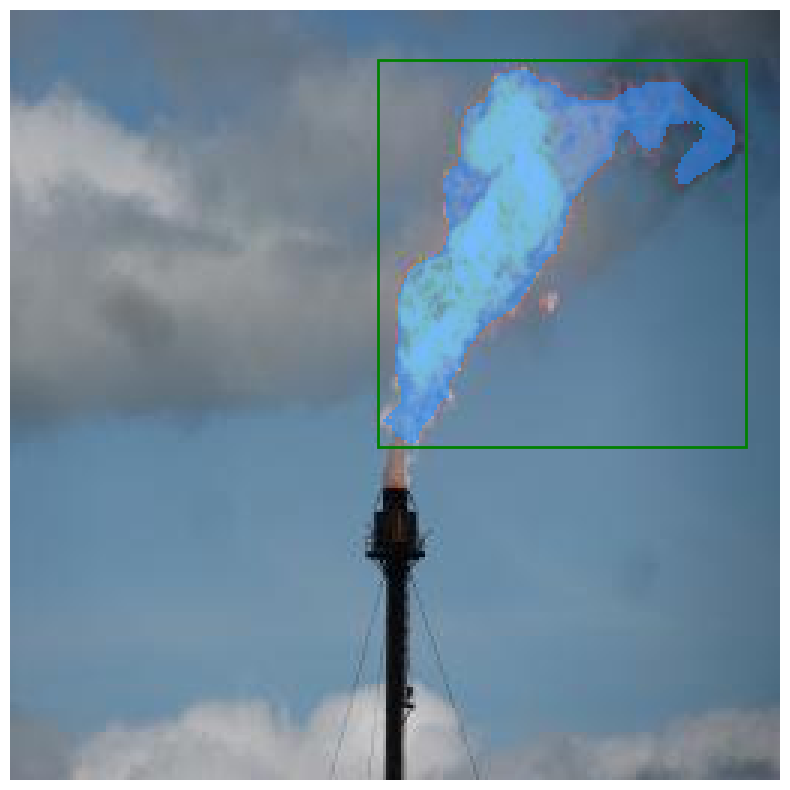

Florence2 inference time for sampledata/test/flare_0057_jpg.rf.7b26d13c822a35706b3d4ab610da9e70.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0057_jpg.rf.7b26d13c822a35706b3d4ab610da9e70.jpg: 0.14 seconds


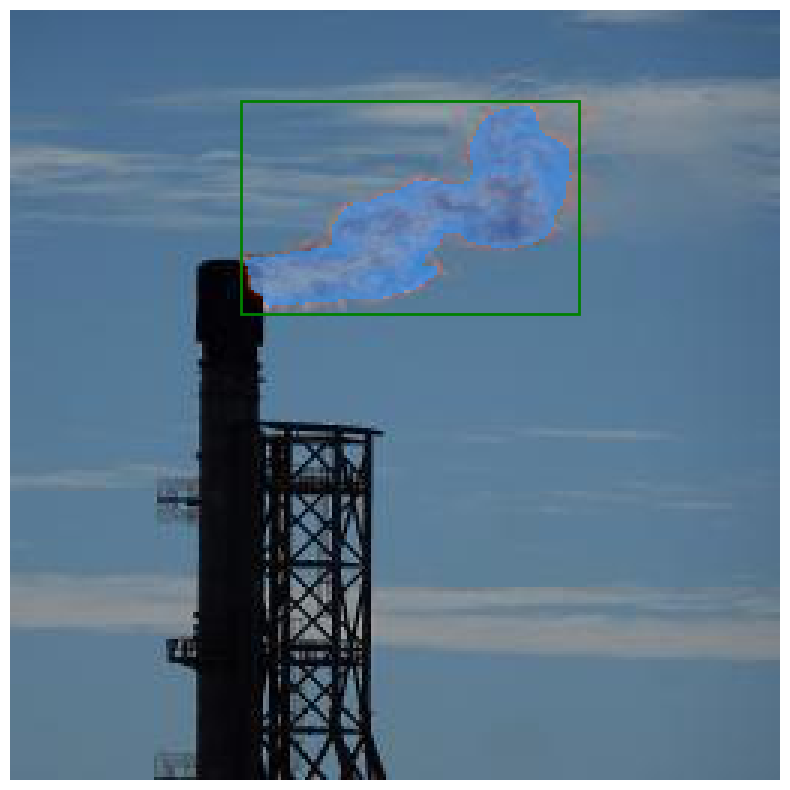

Florence2 inference time for sampledata/test/flare_0188_png_jpg.rf.d2a8f689b36647e2768a7cee8e73d453.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0188_png_jpg.rf.d2a8f689b36647e2768a7cee8e73d453.jpg: 0.14 seconds


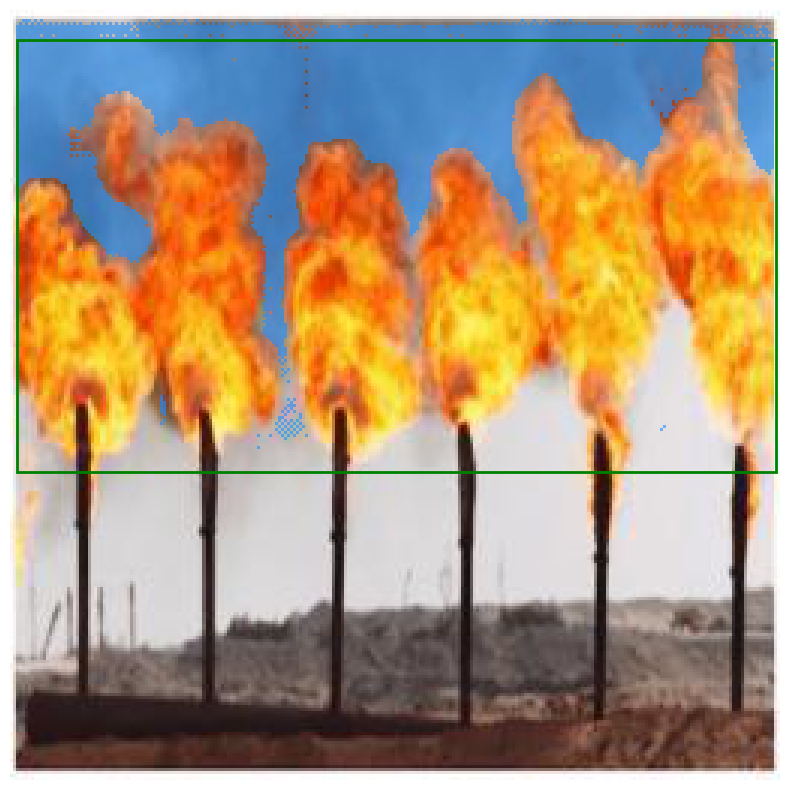

Florence2 inference time for sampledata/test/flare_0199_jpg.rf.e20913c2f95c18dae267eed64f3e11a3.jpg: 0.13 seconds
SAM2 inference time for sampledata/test/flare_0199_jpg.rf.e20913c2f95c18dae267eed64f3e11a3.jpg: 0.14 seconds


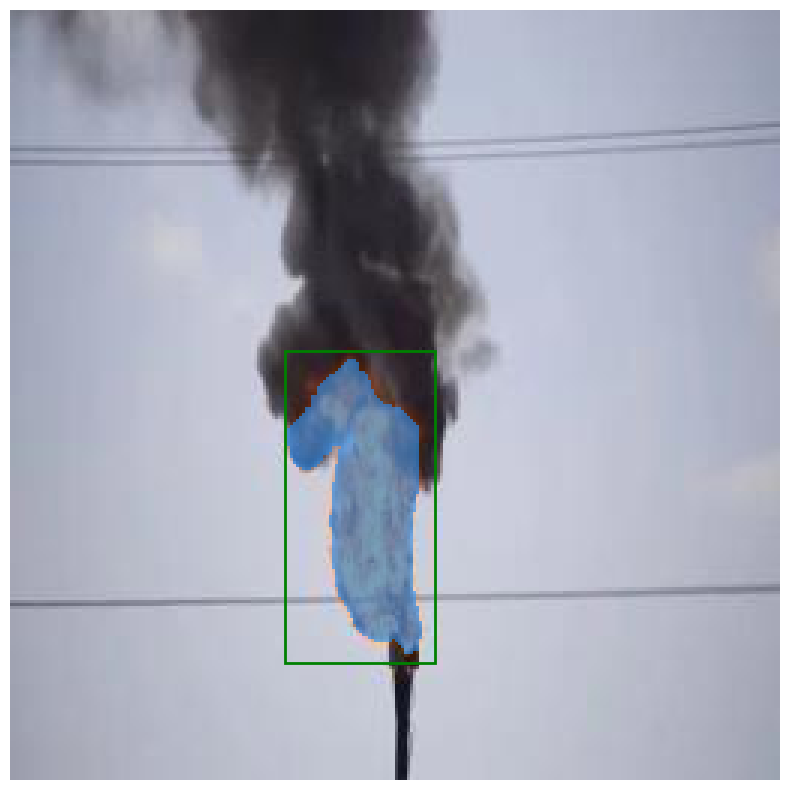

Florence2 inference time for sampledata/test/flare_0125_jpg.rf.f3698415a3f3fdaacfc42c055ea5a5c4.jpg: 0.23 seconds
SAM2 inference time for sampledata/test/flare_0125_jpg.rf.f3698415a3f3fdaacfc42c055ea5a5c4.jpg: 0.14 seconds


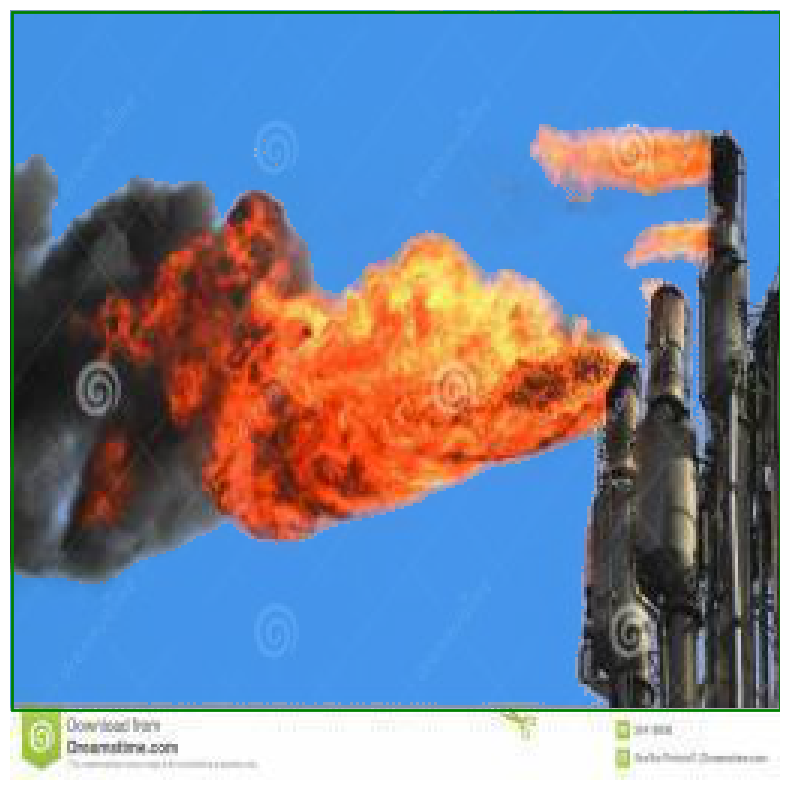

Florence2 inference time for sampledata/test/flare_0164_jpg.rf.50007082c4e4d079ccf447a2e92ff201.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0164_jpg.rf.50007082c4e4d079ccf447a2e92ff201.jpg: 0.14 seconds


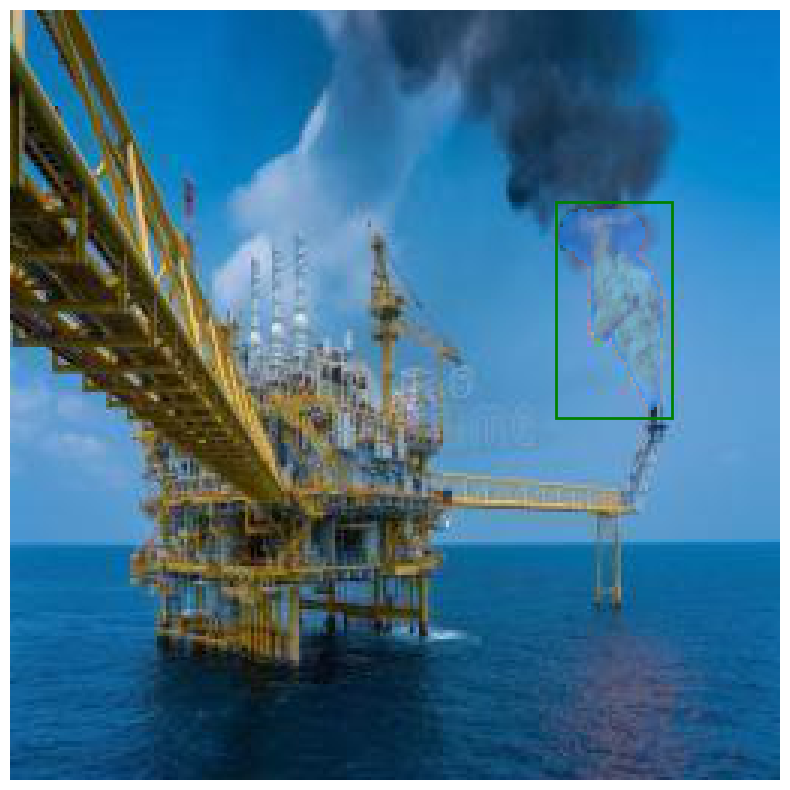

Florence2 inference time for sampledata/test/flare_0028_jpg.rf.f27f324c57c833b85df2c84c5289f4da.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0028_jpg.rf.f27f324c57c833b85df2c84c5289f4da.jpg: 0.14 seconds


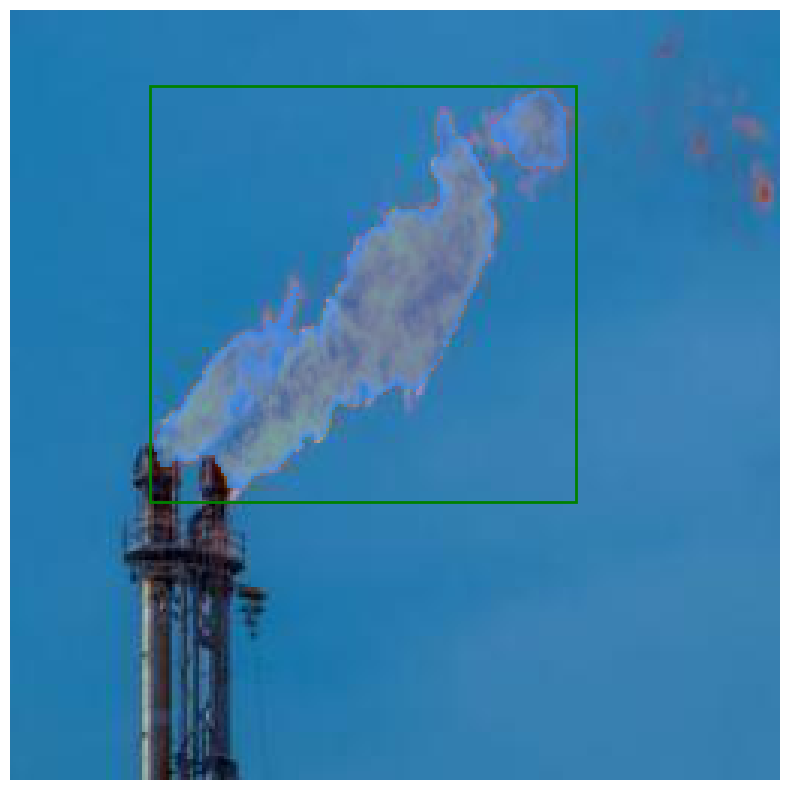

Florence2 inference time for sampledata/test/flare_0060_jpg.rf.0a8a88a652b41753c3768bd21f469ee5.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0060_jpg.rf.0a8a88a652b41753c3768bd21f469ee5.jpg: 0.14 seconds


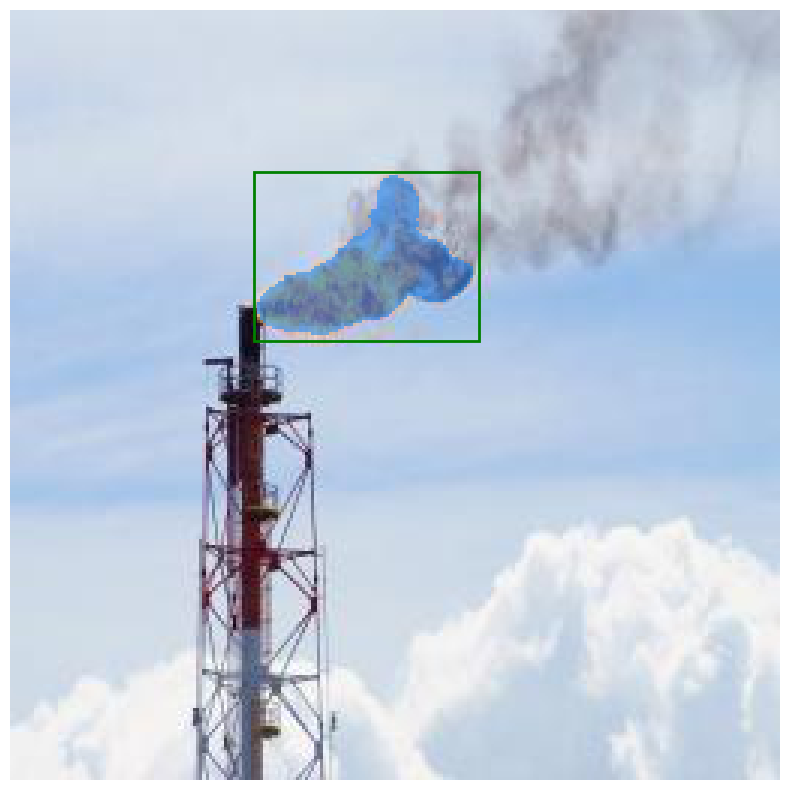

Florence2 inference time for sampledata/test/flare_0212_jpg.rf.e47cd8b137f69452f23c67f4224f9dce.jpg: 0.13 seconds
SAM2 inference time for sampledata/test/flare_0212_jpg.rf.e47cd8b137f69452f23c67f4224f9dce.jpg: 0.14 seconds


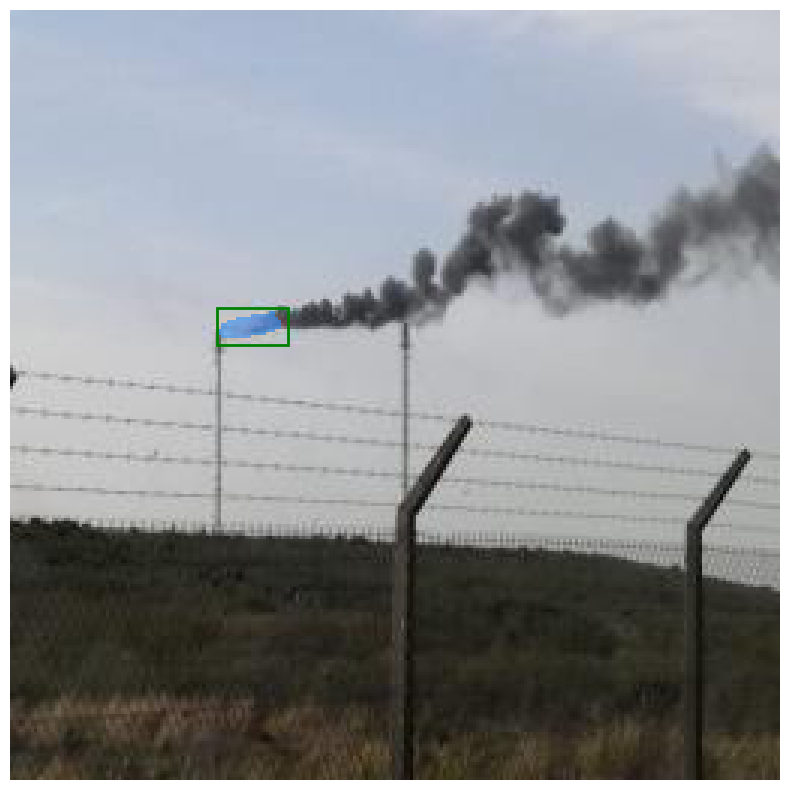

Florence2 inference time for sampledata/test/flare_0217_jpg.rf.c7d3f21fb4751fc3c7a680bd0b27f517.jpg: 0.16 seconds
SAM2 inference time for sampledata/test/flare_0217_jpg.rf.c7d3f21fb4751fc3c7a680bd0b27f517.jpg: 0.14 seconds


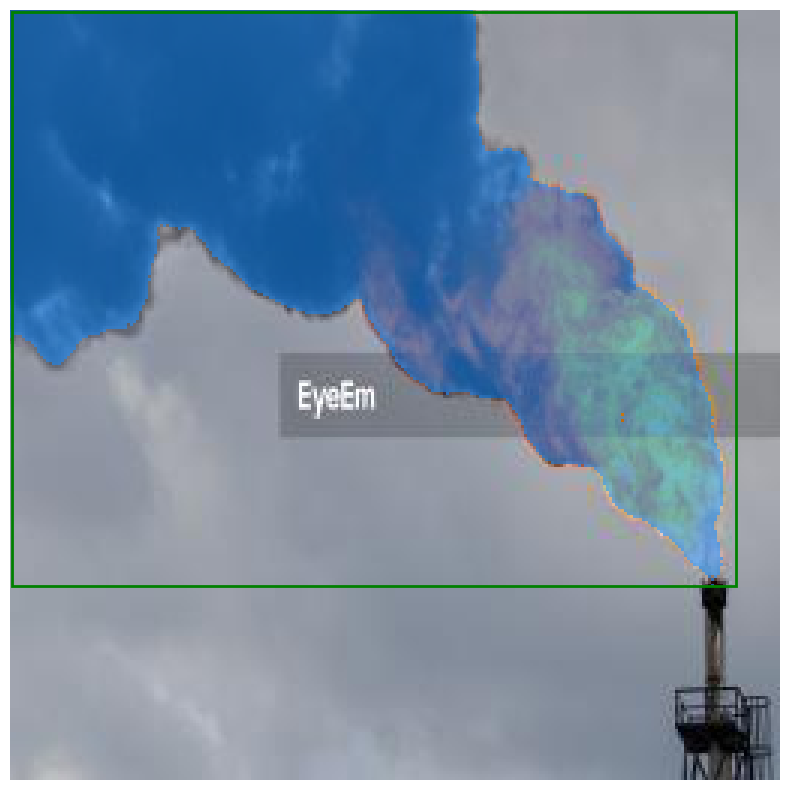

Florence2 inference time for sampledata/test/flare_0074_jpg.rf.3df2e6862c58668fae6bec315dca868f.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0074_jpg.rf.3df2e6862c58668fae6bec315dca868f.jpg: 0.14 seconds


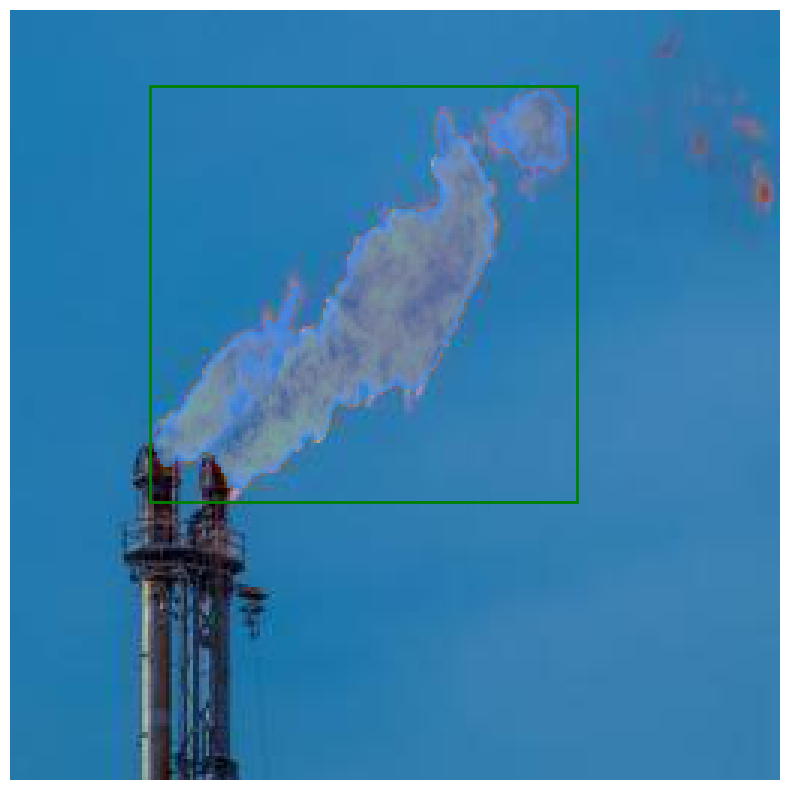

Florence2 inference time for sampledata/test/flare_0058_jpg.rf.d523c196faf6d6839608425728cea69c.jpg: 0.12 seconds
SAM2 inference time for sampledata/test/flare_0058_jpg.rf.d523c196faf6d6839608425728cea69c.jpg: 0.14 seconds


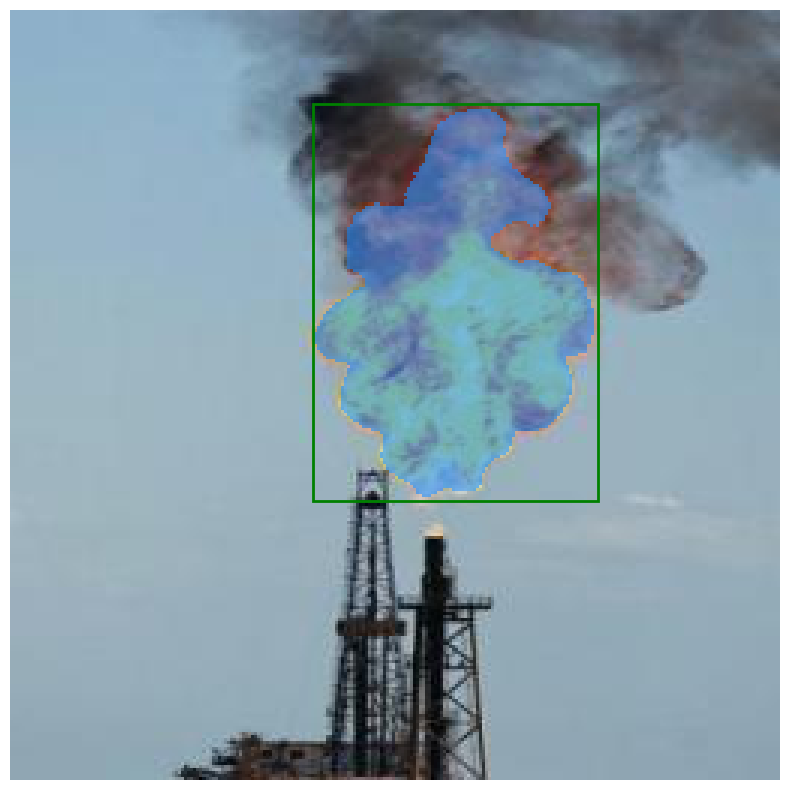

In [9]:
directory = 'sampledata/test/'
all_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.jpg')]

for image_path in all_files[0:]:

    image = Image.open(image_path)

    # task_prompt = '<CAPTION>'
    # task_prompt = '<OD>'
    # task_prompt = '<DENSE_REGION_CAPTION>'
    # task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
    task_prompt = '<OPEN_VOCABULARY_DETECTION>'
    text_input = 'fire'

    start_time_florence2 = time.time()  # Start timing florence2
    results = florence2_inference(task_prompt, text_input=text_input)
    end_time_florence2 = time.time()  # End timing florence2

    florence2_time = end_time_florence2 - start_time_florence2
    print(f"Florence2 inference time for {image_path}: {florence2_time:.2f} seconds")
    
    bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])
    plot_bbox(image, bbox_results, save_path = f'inference_output/florence2_{text_input.replace(" ", "_")}_{image_path.split("/")[-1]}')

    predictor.set_image(image)

    input_box = np.array(results[task_prompt]['bboxes'][0])
    input_point = np.array([[]])
    input_label = np.array([])

    start_time_sam2 = time.time()  # Start timing SAM2
    masks, scores, logits = sam2_inference(predictor=predictor, input_box=input_box, input_point=input_point, input_label=input_label)
    end_time_sam2 = time.time()  # End timing SAM2

    sam2_time = end_time_sam2 - start_time_sam2
    print(f"SAM2 inference time for {image_path}: {sam2_time:.2f} seconds")

    # print(masks, scores, logits)
    show_masks(image, masks, scores, save_path = f'inference_output/sam2_{text_input.replace(" ", "_")}_{image_path.split("/")[-1]}', box_coords=input_box, borders=False)